In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
bitcoin = pd.read_csv('Bitcoin1.csv', sep=';')
bitcoin = bitcoin.iloc[::-1].reset_index(drop=True)


In [16]:
print(len(bitcoin))
print(bitcoin.columns)
print(bitcoin.dtypes)

4990
Index(['timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'name', 'open', 'high',
       'low', 'close', 'volume', 'marketCap', 'timestamp'],
      dtype='object')
timeOpen      object
timeClose     object
timeHigh      object
timeLow       object
name           int64
open         float64
high         float64
low          float64
close        float64
volume       float64
marketCap    float64
timestamp     object
dtype: object


In [28]:
print(bitcoin.name.unique())
print('Min: ', bitcoin.close.min(), '/', 'Max: ', bitcoin.close.max())
print(bitcoin.timestamp.min(), '/', bitcoin.timestamp.max())

[2781]
Min:  0.05640216 / Max:  69019.7863638058
2010-07-13T23:59:59.999Z / 2024-03-10T23:59:59.999Z


In [21]:
bitcoin.describe()

,name,open,high,low,close,volume,marketCap
count,4990.0,4990.000000,4990.000000,4990.000000,4990.000000,4.990000e+03,4.990000e+03
mean,2781.0,10637.429418,10887.288210,10374.185174,10650.373939,1.168221e+10,1.995255e+11
std,0.0,15607.658183,15982.658573,15208.576051,15626.558619,1.773942e+10,2.980340e+11
min,2781.0,0.056403,0.061552,0.048647,0.056402,0.000000e+00,1.902596e+05
25%,2781.0,226.140003,230.526745,222.466003,226.398750,2.141742e+05,3.185439e+09
50%,2781.0,1734.214966,1812.895020,1690.275024,1746.895020,7.514705e+08,2.852100e+10
75%,2781.0,14663.475342,15485.707338,13794.399902,14688.450195,2.026604e+10,2.544138e+11
max,2781.0,68500.255854,70083.051624,68239.980387,69019.786364,3.509679e+11,1.356284e+12


In [37]:
bitcoin.isnull().mean()

timeOpen     0.0
timeClose    0.0
timeHigh     0.0
timeLow      0.0
name         0.0
open         0.0
high         0.0
low          0.0
close        0.0
volume       0.0
marketCap    0.0
timestamp    0.0
dtype: float64

Text(0, 0.5, 'Frequency')

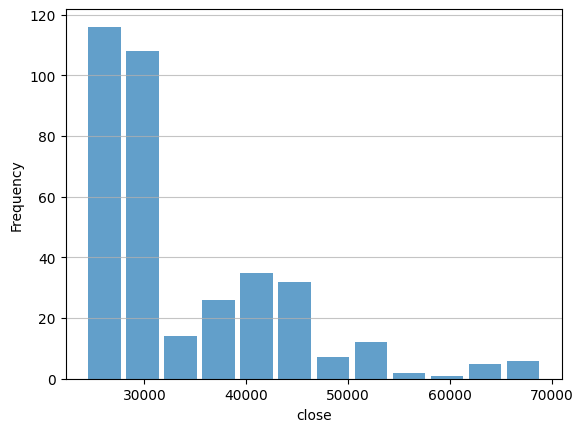

In [57]:
n, bins, patches = plt.hist(x=bitcoin['close'], bins='auto', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('close')
plt.ylabel('Frequency')

In [7]:
from scipy import stats
def ignore_nans(a, b):
    index = ~a.isnull() & ~b.isnull()
    return a[index], b[index]
stats.pearsonr(*ignore_nans(bitcoin['close'], bitcoin['marketCap']))

PearsonRResult(statistic=0.9995982765006826, pvalue=0.0)

c:\Users\Asus\anaconda3\lib\site-packages\dython\nominal.py:736: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[i], columns[j]] = _inf_nan_str(ij)
c:\Users\Asus\anaconda3\lib\site-packages\dython\nominal.py:737: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[j], columns[i]] = _inf_nan_str(ji)


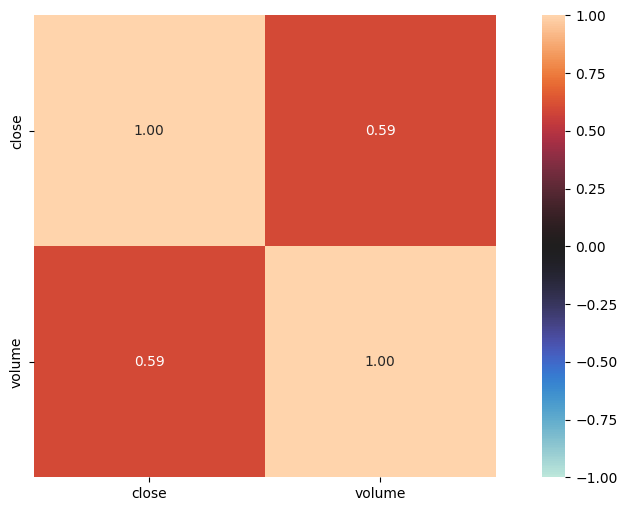

{'corr':            close    volume
 close   1.000000  0.594508
 volume  0.594508  1.000000,
 'ax': <Axes: >}

In [56]:
import dython
dython.nominal.associations(bitcoin[['close', 'volume']], figsize=(12, 6))

Text(37.722222222222214, 0.5, 'marketCap')

<Figure size 1200x600 with 0 Axes>

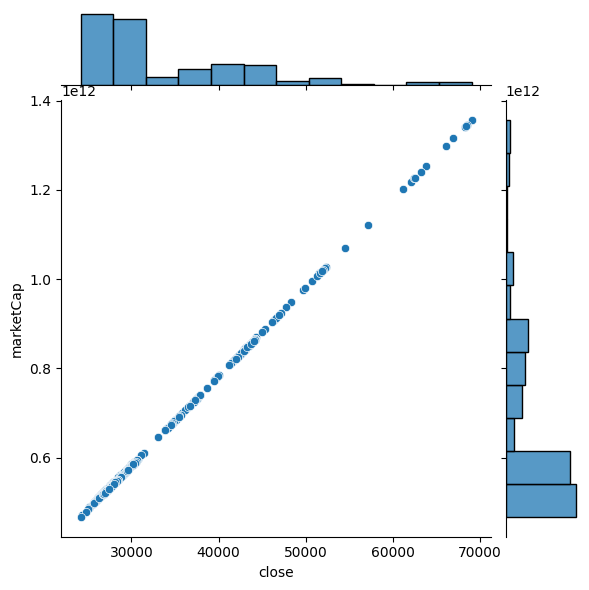

In [58]:
plt.figure(figsize=(12, 6))
sns.jointplot(x="close", y="marketCap", edgecolor="white", data=bitcoin)
plt.xlabel("close")
plt.ylabel("marketCap")

In [4]:
bitcoin = bitcoin[['timestamp', 'close']]
bitcoin['timestamp'] = pd.to_datetime(bitcoin['timestamp'])
bitcoin.set_index('timestamp', inplace=True)

In [52]:
from numpy import polyfit

def fit(X, y, degree=3):
    coef = polyfit(X, y, degree)
    trendpoly = np.poly1d(coef)
    return trendpoly(X)
def get_season(s, yearly_periods=4, degree=3):
    X = [i%(365/yearly_periods) for i in range(0, len(s))]
    seasonal = fit(X, s.values, degree)
    return pd.Series(data=seasonal, index=s.index)
def get_trend(s, degree=3):
    X = list(range(len(s)))
    trend = fit(X, s.values, degree)
    return pd.Series(data=trend, index=s.index)

Text(0, 0.5, 'Temperature change')

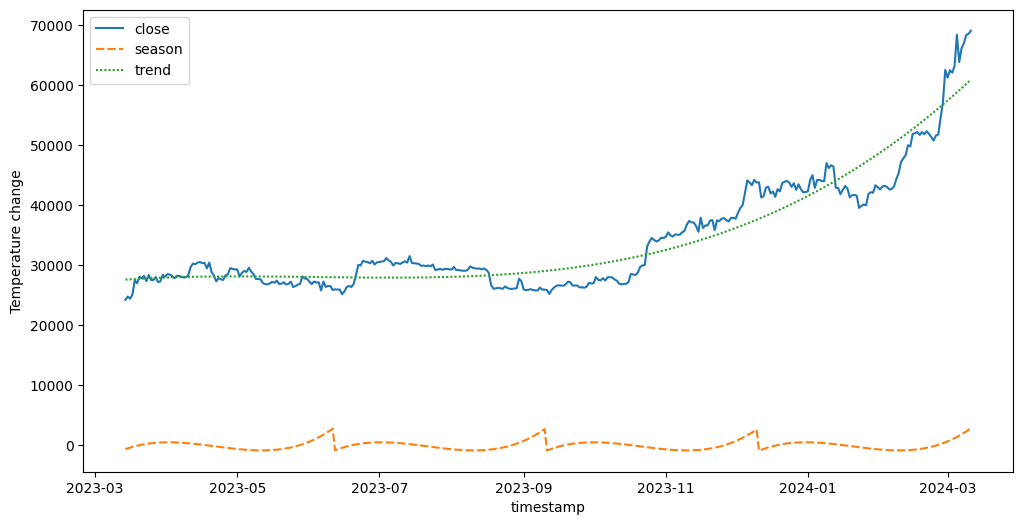

In [53]:
plt.figure(figsize=(12, 6))
bitcoin['trend'] = get_trend(bitcoin['close'])
bitcoin['season'] = get_season(bitcoin['close'] - bitcoin['trend'])
sns.lineplot(data=bitcoin[['close', 'season', 'trend']])
plt.ylabel('Temperature change')

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

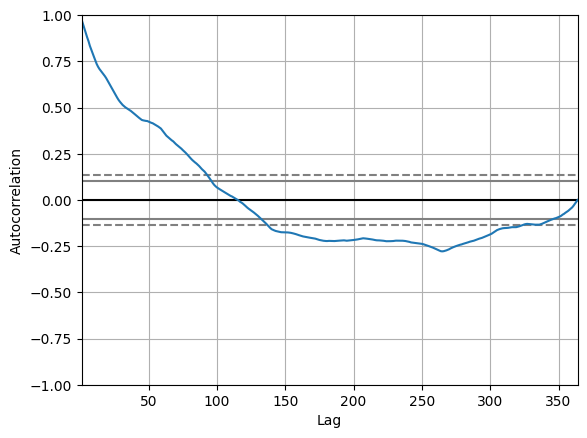

In [5]:
pd.plotting.autocorrelation_plot(bitcoin['close'])

In [6]:
from statsmodels.tsa import stattools
stattools.adfuller(bitcoin['close'])

(-4.6096364396667395,
 0.00012398874616338854,
 2,
 361,
 {'1%': -3.4485948978753314,
  '5%': -2.86957971128312,
  '10%': -2.571053050314224},
 5551.7056345239325)

**=========================================================================================================================**
**=========================================================================================================================**
**=========================================================================================================================**
**=========================================================================================================================**

## Naive Prediction or Baseline Models ##

Implementing the historical mean baseline

In [45]:
print(len(bitcoin))
train = bitcoin[:-30]
test = bitcoin[-30:]
print(len(train))
print(len(test))

364
334
30


In [46]:
historical_mean = np.mean(train['close']) 
print(historical_mean)

32078.644465130743


In [48]:
test.loc[:, 'pred_mean'] = historical_mean

Mean Absolute Percentage Error (MAPE)

In [49]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_hist_mean = mape(test['close'], test['pred_mean'])
print(mape_hist_mean)

42.90579641835103


In [50]:
bitcoin.tail()

,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp
359,2024-03-06T00:00:00.000Z,2024-03-06T23:59:59.999Z,2024-03-06T08:35:00.000Z,2024-03-06T03:00:00.000Z,2781,63776.051426,67637.929859,62848.671519,66106.802787,6.875023e+10,1.298635e+12,2024-03-06T23:59:59.999Z
360,2024-03-07T00:00:00.000Z,2024-03-07T23:59:59.999Z,2024-03-07T17:26:00.000Z,2024-03-07T01:11:00.000Z,2781,66099.741652,68029.918692,65655.534200,66925.483202,4.698954e+10,1.315182e+12,2024-03-07T23:59:59.999Z
361,2024-03-08T00:00:00.000Z,2024-03-08T23:59:59.999Z,2024-03-08T15:32:00.000Z,2024-03-08T16:13:00.000Z,2781,66938.093485,70083.051624,66230.452140,68300.095691,5.920288e+10,1.341993e+12,2024-03-08T23:59:59.999Z
362,2024-03-09T00:00:00.000Z,2024-03-09T23:59:59.999Z,2024-03-09T07:12:00.000Z,2024-03-09T02:02:00.000Z,2781,68299.259726,68673.058034,68053.125219,68498.881304,2.160965e+10,1.346015e+12,2024-03-09T23:59:59.999Z
363,2024-03-10T00:00:00.000Z,2024-03-10T23:59:59.999Z,2024-03-10T10:22:00.000Z,2024-03-10T22:58:00.000Z,2781,68500.255854,70005.199901,68239.980387,69019.786364,3.568398e+10,1.356284e+12,2024-03-10T23:59:59.999Z


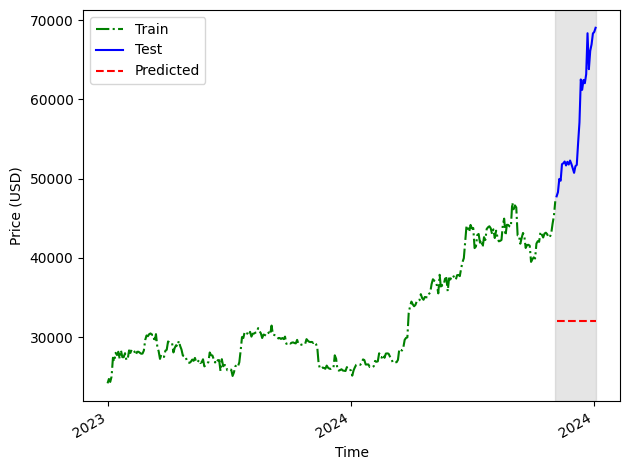

In [51]:
fig, ax = plt.subplots()
ax.plot(train['timestamp'], train['close'], 'g-.', label='Train')
ax.plot(test['timestamp'], test['close'], 'b-', label='Test')
ax.plot(test['timestamp'], test['pred_mean'], 'r--', label='Predicted')
ax.set_xlabel('Time')
ax.set_ylabel('Price (USD)')
ax.axvspan(333, 363, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks(np.arange(0, 363, 181), [2023, 2024, 2024])
fig.autofmt_xdate()
plt.tight_layout()

Predicting using the last known value

In [35]:
last1 = train[-1:]['close']
print(last1)
last2 = train['close'].iloc[-1]
print(last2)
last3 = train['close'][-1:].values
print(last3)
last = train.close.iloc[-1]
print(last)

333    47147.200313
Name: close, dtype: float64
47147.2003126111
[47147.20031261]
47147.2003126111


In [20]:
test.loc[:, 'pred_last'] = last
mape_last = mape(test['close'], test['pred_last'])
print(mape_last)

16.08648377025394


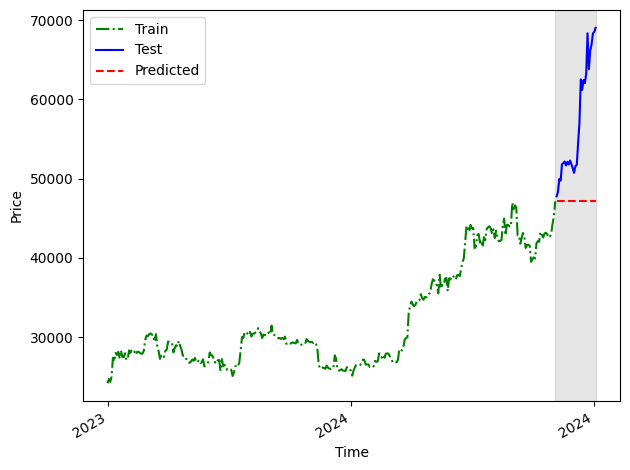

In [29]:
fig, ax = plt.subplots()
ax.plot(train['timestamp'], train['close'], 'g-.', label='Train')
ax.plot(test['timestamp'], test['close'], 'b-', label='Test')
ax.plot(test['timestamp'], test['pred_last'], 'r--', label='Predicted')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.axvspan(333, 363, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks(np.arange(0, 363, 181), [2023, 2024, 2024])
fig.autofmt_xdate()
plt.tight_layout()

Simulating a random walk process

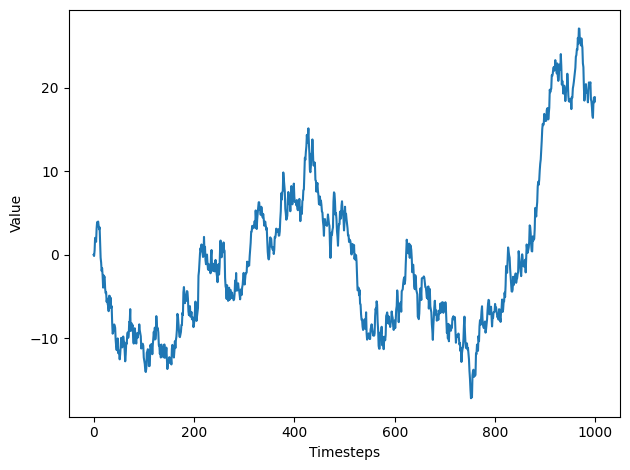

In [7]:
np.random.seed(42)
steps = np.random.standard_normal(1000)
steps[0]=0
random_walk = np.cumsum(steps)
fig, ax = plt.subplots()
ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
plt.tight_layout()

Test for stationarity and plot ACF function

ADF Statistic: 2.710304802127979
p-value: 0.9990874934519166


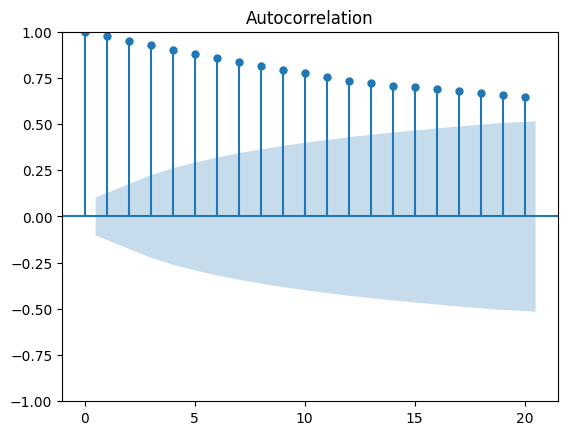

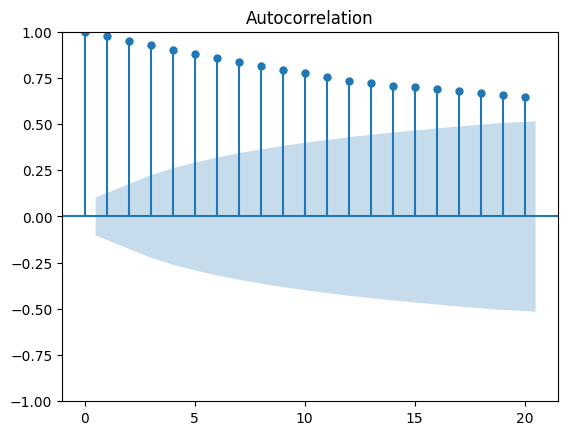

In [12]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

ADF_result = adfuller(bitcoin['close'].values)
print(f'ADF Statistic: {ADF_result[0]}') 
print(f'p-value: {ADF_result[1]}')

plot_acf(bitcoin['close'].values, lags=20)

bitcoin time series data is autocorrelated and not stationary.

Apply a first-order differencing to make it stationary in order to retrieve useful information from the ACF plot.

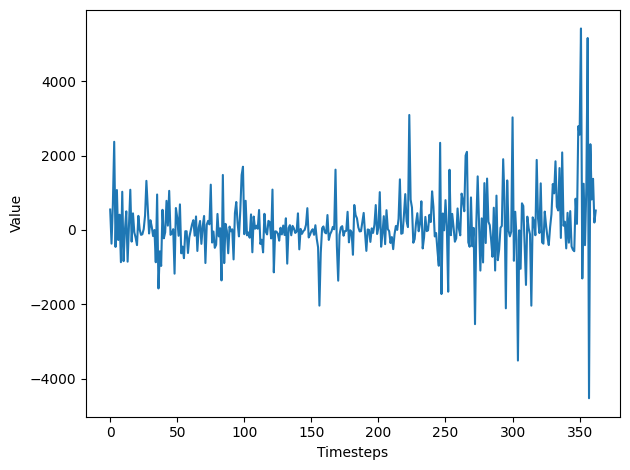

In [22]:
diff_bitcoin = np.diff(bitcoin['close'].values, n=1)
fig, ax = plt.subplots()
ax.plot(diff_bitcoin)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
plt.tight_layout()

Test for stationarity and plot ACF function again.

ADF Statistic: -12.320910129203334
p-value: 6.754467770365742e-23


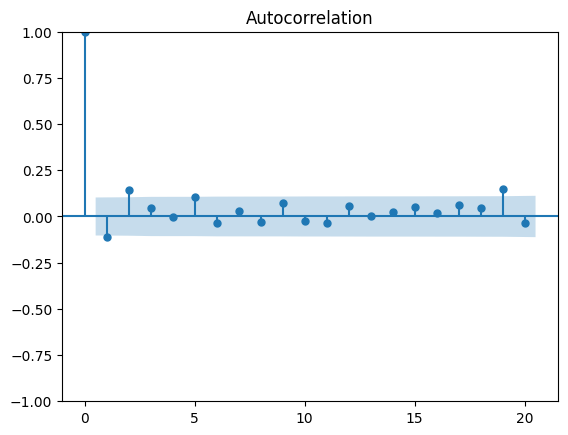

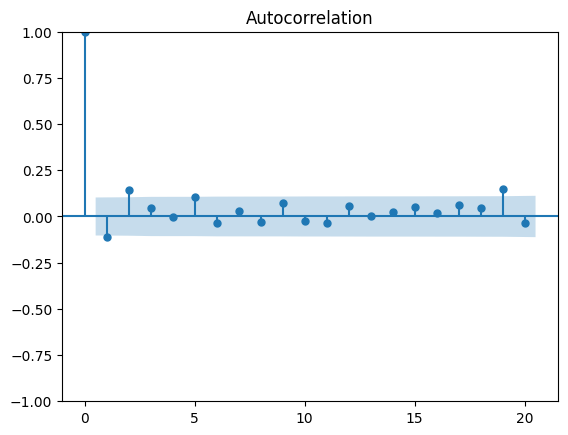

In [23]:
ADF_result = adfuller(diff_bitcoin) 
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')
plot_acf(diff_bitcoin, lags=20)

Transformed bitcoin time series data is correlated and stationary. So we have a stationary moving average process of order 2.

## Forecasting a random walk ##

Forecasting on a long horizon

Drift Baseline Model

In [3]:
train = bitcoin[:-30]
test = bitcoin[-30:]

In [11]:
last_value = train['close'][-1:].values
first_value = train['close'][:1].values
deltaX = 334 - 1
deltaY = last_value - first_value
train.tail()

,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp
329,2024-02-05T00:00:00.000Z,2024-02-05T23:59:59.999Z,2024-02-05T13:38:00.000Z,2024-02-05T01:14:00.000Z,2781,42577.622981,43494.248632,42264.817297,42658.666048,1.871549e+10,8.369361e+11,2024-02-05T23:59:59.999Z
330,2024-02-06T00:00:00.000Z,2024-02-06T23:59:59.999Z,2024-02-06T16:31:00.000Z,2024-02-06T01:05:00.000Z,2781,42657.391074,43344.148218,42529.021423,43084.671864,1.679848e+10,8.453385e+11,2024-02-06T23:59:59.999Z
331,2024-02-07T00:00:00.000Z,2024-02-07T23:59:59.999Z,2024-02-07T21:32:00.000Z,2024-02-07T03:59:00.000Z,2781,43090.021297,44341.948333,42775.958471,44318.224451,2.112659e+10,8.695853e+11,2024-02-07T23:59:59.999Z
332,2024-02-08T00:00:00.000Z,2024-02-08T23:59:59.999Z,2024-02-08T20:18:00.000Z,2024-02-08T00:00:00.000Z,2781,44332.125602,45575.841721,44332.125602,45301.566629,2.615452e+10,8.889215e+11,2024-02-08T23:59:59.999Z
333,2024-02-09T00:00:00.000Z,2024-02-09T23:59:59.999Z,2024-02-09T18:25:00.000Z,2024-02-09T00:50:00.000Z,2781,45297.384253,48152.494628,45260.824572,47147.200313,3.931677e+10,9.251845e+11,2024-02-09T23:59:59.999Z


Calculate the drift:

In [16]:
drift = deltaY / deltaX
print(drift)
x_vals = np.arange(334, 364, 1)
pred_drift = drift * x_vals + first_value
test.loc[:, 'pred_drift'] = pred_drift
test.head()

[68.91791986]


,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp,pred_drift
334,2024-02-10T00:00:00.000Z,2024-02-10T23:59:59.999Z,2024-02-10T20:48:00.000Z,2024-02-10T10:54:00.000Z,2781,47153.528425,48146.170431,46905.321686,47771.277367,1.639868e+10,9.374767e+11,2024-02-10T23:59:59.999Z,47216.118232
335,2024-02-11T00:00:00.000Z,2024-02-11T23:59:59.999Z,2024-02-11T04:01:00.000Z,2024-02-11T01:29:00.000Z,2781,47768.968130,48535.935910,47617.405365,48293.916751,1.931587e+10,9.477742e+11,2024-02-11T23:59:59.999Z,47285.036152
336,2024-02-12T00:00:00.000Z,2024-02-12T23:59:59.999Z,2024-02-12T21:15:00.000Z,2024-02-12T10:08:00.000Z,2781,48296.385196,50280.475274,47745.760261,49958.224219,3.451199e+10,9.804910e+11,2024-02-12T23:59:59.999Z,47353.954072
337,2024-02-13T00:00:00.000Z,2024-02-13T23:59:59.999Z,2024-02-13T01:37:00.000Z,2024-02-13T17:13:00.000Z,2781,49941.361162,50358.392086,48406.495564,49742.440990,3.559305e+10,9.762999e+11,2024-02-13T23:59:59.999Z,47422.871992
338,2024-02-14T00:00:00.000Z,2024-02-14T23:59:59.999Z,2024-02-14T14:38:00.000Z,2024-02-14T04:37:00.000Z,2781,49733.444799,52021.370779,49296.830923,51826.695996,3.910561e+10,1.017254e+12,2024-02-14T23:59:59.999Z,47491.789912


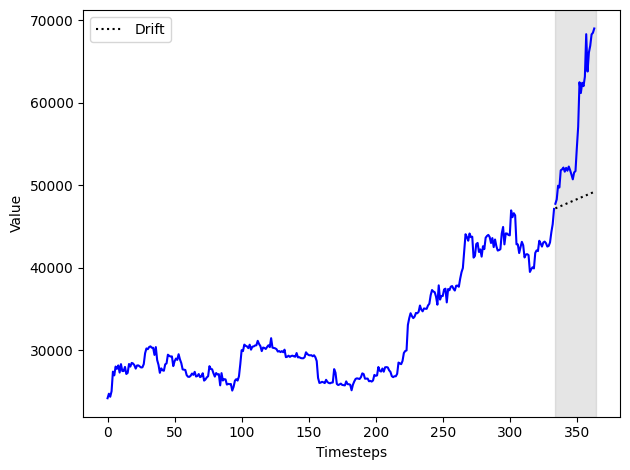

In [23]:
fig, ax = plt.subplots()
ax.plot(train['close'], 'b-')
ax.plot(test['close'], 'b-')
ax.plot(test['pred_drift'], 'k:', label='Drift')
ax.axvspan(334, 364, color='#808080', alpha=0.2)
ax.legend(loc=2)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
plt.tight_layout()

In [24]:
from sklearn.metrics import mean_squared_error
mse_drift = mean_squared_error(test['close'], test['pred_drift'])
print(mse_drift)

120156287.10122515


## Forecasting the moving average process ##

In [3]:
diff_bitcoin = np.diff(bitcoin['close'].values, n=1)
df_diff = pd.DataFrame({'diff_bitcoin': diff_bitcoin})
train = df_diff[:-30]
test = df_diff[-30:]
print(len(train))
print(len(test))

333
30


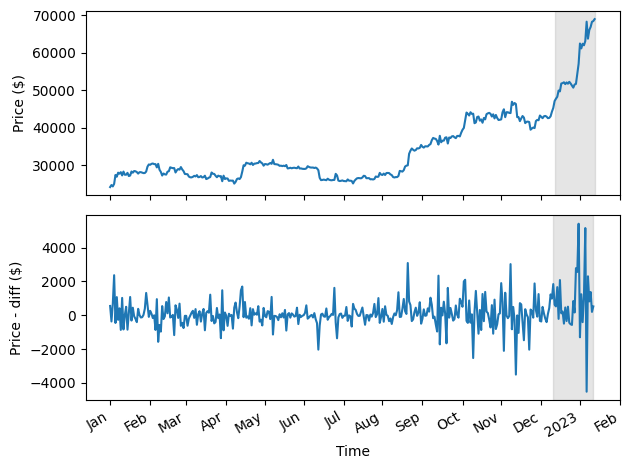

In [4]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(bitcoin['close'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Price ($)')
ax1.axvspan(333, 363, color='#808080', alpha=0.2)

ax2.plot(df_diff['diff_bitcoin'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Price - diff ($)')
ax2.axvspan(332, 362, color='#808080', alpha=0.2)

plt.xticks([0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2023', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

A function for rolling forecasts on a horizon

In [54]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA    

In [55]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head()

,diff_bitcoin,pred_mean,pred_last_value,pred_MA
333,624.077054,68.917920,1845.633684,-66.164000
334,522.639383,68.917920,1845.633684,154.096824
335,1664.307468,71.929504,522.639383,29.845386
336,-215.783229,71.929504,522.639383,37.520868
337,2084.255006,75.800914,-215.783229,169.870310


In [56]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['diff_bitcoin'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['diff_bitcoin'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['diff_bitcoin'], pred_df['pred_MA'])

print(mse_mean, mse_last, mse_MA)

3679218.550366001 6631811.723600163 3657607.1642355025


In [57]:
bitcoin['pred_price'] = pd.Series()
bitcoin['pred_price'][334:] = bitcoin['close'].iloc[333] + pred_df['pred_MA'].cumsum()

C:\Users\baloochyb\AppData\Local\Temp\ipykernel_10064\2233923135.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  bitcoin['pred_price'][334:] = bitcoin['close'].iloc[333] + pred_df['pred_MA'].cumsum()
C:\Users\baloochyb\AppData\Local\Temp

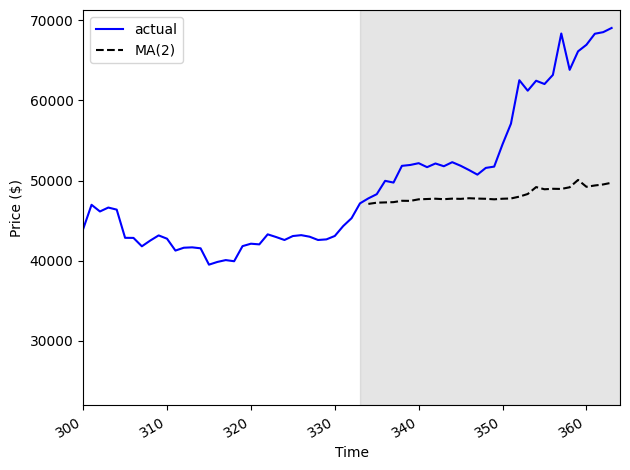

In [58]:
fig, ax = plt.subplots()

ax.plot(bitcoin['close'], 'b-', label='actual') 
ax.plot(bitcoin['pred_price'], 'k--', label='MA(2)') 
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Price ($)')
ax.axvspan(333, 364, color='#808080', alpha=0.2)
ax.set_xlim(300, 364)
fig.autofmt_xdate()
plt.tight_layout()

In [62]:
from sklearn.metrics import mean_absolute_error

mae_MA_undiff = mean_absolute_error(bitcoin['close'].iloc[334:], bitcoin['pred_price'].iloc[334:])
print(mae_MA_undiff)

8829.476831050439


Partial Autocorrelation Function (PACF)

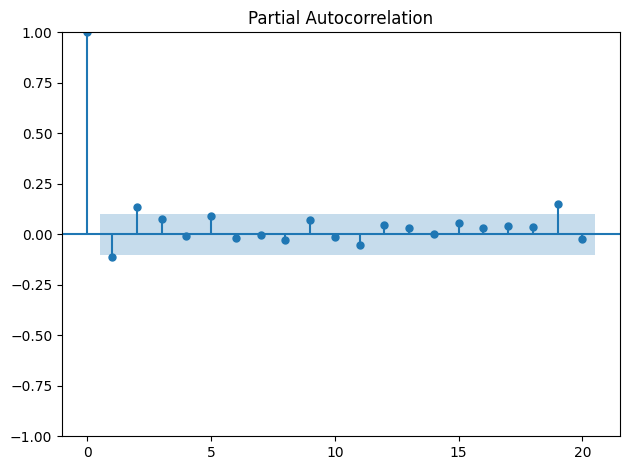

In [4]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(diff_bitcoin, lags=20)
plt.tight_layout()

Forecasting an autoregressive process

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    end_idx = train_len
    if method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean
    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value
    elif method == 'AR':
        pred_AR = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
        return pred_AR

In [66]:
TRAIN_LEN = len(train) 
HORIZON = len(test) 
WINDOW = 1

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean 
test['pred_last_value'] = pred_last_value 
test['pred_AR'] = pred_AR

test.head()

C:\Users\baloochyb\AppData\Local\Temp\ipykernel_12688\3337110254.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_mean'] = pred_mean
C:\Users\baloochyb\AppData\Local\Temp\ipykernel_12688\3337110254.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_last_value'] = pred_last_value
C:\Users\baloochyb\AppData\Local\Temp\ipykernel_12688\3337110254.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

,diff_bitcoin,pred_mean,pred_last_value,pred_AR
333,624.077054,68.917920,1845.633684,-80.947221
334,522.639383,70.580073,624.077054,81.627063
335,1664.307468,71.929504,522.639383,9.550728
336,-215.783229,76.668724,1664.307468,-64.138049
337,2084.255006,75.800914,-215.783229,143.792642


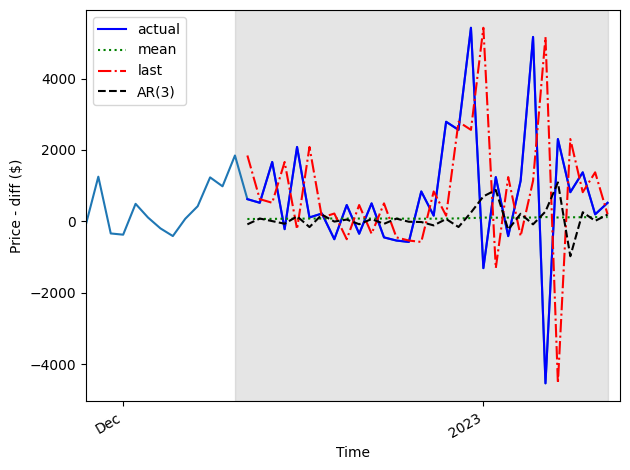

In [67]:
fig, ax = plt.subplots()

ax.plot(df_diff['diff_bitcoin']) 
ax.plot(test['diff_bitcoin'], 'b-', label='actual') 
ax.plot(test['pred_mean'], 'g:', label='mean') 
ax.plot(test['pred_last_value'], 'r-.', label='last') 
ax.plot(test['pred_AR'], 'k--', label='AR(3)')

ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Price - diff ($)')

ax.axvspan(332, 362, color='#808080', alpha=0.2)
ax.set_xlim(320, 363)
plt.xticks([323, 352], ['Dec', '2023'])
fig.autofmt_xdate()
plt.tight_layout()

In [68]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['diff_bitcoin'], test['pred_mean'])
mse_last = mean_squared_error(test['diff_bitcoin'], test['pred_last_value'])
mse_AR = mean_squared_error(test['diff_bitcoin'], test['pred_AR'])
print(mse_mean, mse_last, mse_AR)

3680249.5365142077 8484602.18904163 3761761.570332173


In [69]:
bitcoin['pred_price'] = pd.Series()
bitcoin['pred_price'][334:] = bitcoin['close'].iloc[333] + test['pred_last_value'].cumsum()

C:\Users\baloochyb\AppData\Local\Temp\ipykernel_12688\1686053737.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  bitcoin['pred_price'][334:] = bitcoin['close'].iloc[333] + test['pred_last_value'].cumsum()
C:\Users\baloochyb\AppData\Local

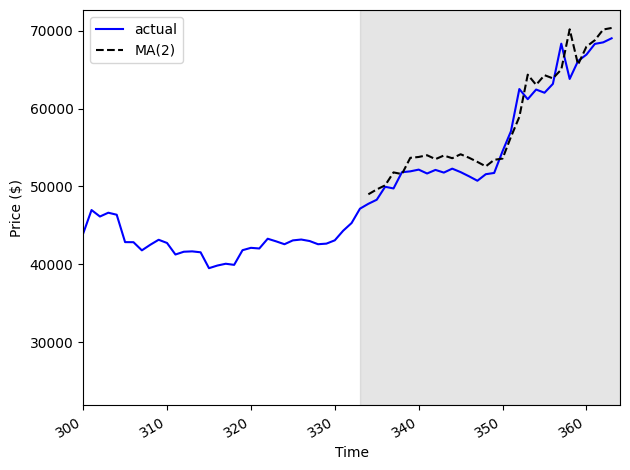

In [70]:
fig, ax = plt.subplots()

ax.plot(bitcoin['close'], 'b-', label='actual') 
ax.plot(bitcoin['pred_price'], 'k--', label='MA(2)') 
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Price ($)')
ax.axvspan(333, 364, color='#808080', alpha=0.2)
ax.set_xlim(300, 364)
fig.autofmt_xdate()
plt.tight_layout()

In [71]:
from sklearn.metrics import mean_absolute_error

mae_MA_undiff = mean_absolute_error(bitcoin['close'].iloc[334:], bitcoin['pred_price'].iloc[334:])
print(mae_MA_undiff)

1733.2578842177022


In [72]:
winrate = 0
profit = 0
loserate = 0
for i in range(334, 364):
    if bitcoin['pred_price'].iloc[i] > bitcoin['close'].iloc[i - 1]:
        if bitcoin['close'].iloc[i - 1] < bitcoin['close'].iloc[i]:
            winrate = winrate +1
        else:
            loserate = loserate +1
        profit = profit + (bitcoin['close'].iloc[i] - bitcoin['close'].iloc[i - 1])
print(winrate)
print(loserate)
print(profit)

21
9
21872.586051194703


## General modeling procedure for an ARMA(p,q) ##

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

bitcoin = pd.read_csv('Bitcoin2.csv', sep=';')
bitcoin = bitcoin.iloc[::-1].reset_index(drop=True)

In [24]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

ADF_result = adfuller(bitcoin['close'].values)
print(f'ADF Statistic: {ADF_result[0]}') 
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.38850644004741347
p-value: 0.912000175776325


In [25]:
diff_bitcoin = np.diff(bitcoin['close'].values, n=1)
df_diff = pd.DataFrame({'diff_bitcoin': diff_bitcoin})
train = df_diff[:-30]
test = df_diff[-30:]
print(len(train))
print(len(test))

333
30


In [26]:
ADF_result = adfuller(diff_bitcoin)
print(f'ADF Statistic: {ADF_result[0]}') 
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -3.9772361266985063
p-value: 0.0015345140737444093


Defining a list of possible values for p and q.

In [21]:
from itertools import product

ps = range(0, 9, 1)
qs = range(0, 9, 1)

order_list = list(product(ps, qs))


Function to fit all unique ARMA(p,q) models

In [5]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

"train" is stationary.

In [30]:
result_df = optimize_ARMA(train['diff_bitcoin'], order_list)
result_df

C:\Users\baloochyb\AppData\Local\Temp\ipykernel_1056\3775156193.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/81 [00:00<?, ?it/s]

c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA pa

,"(p,q)",AIC
0,"(8, 6)",5629.034579
1,"(2, 5)",5629.134541
2,"(3, 5)",5630.240953
3,"(4, 3)",5630.441935
4,"(5, 2)",5630.478939
...,...,...
76,"(5, 5)",5641.468911
77,"(5, 6)",5642.041637
78,"(8, 4)",5642.461868
79,"(0, 0)",5643.073652


Residual Analysis

In [39]:
model = SARIMAX(train['diff_bitcoin'], order=(2,0,5), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

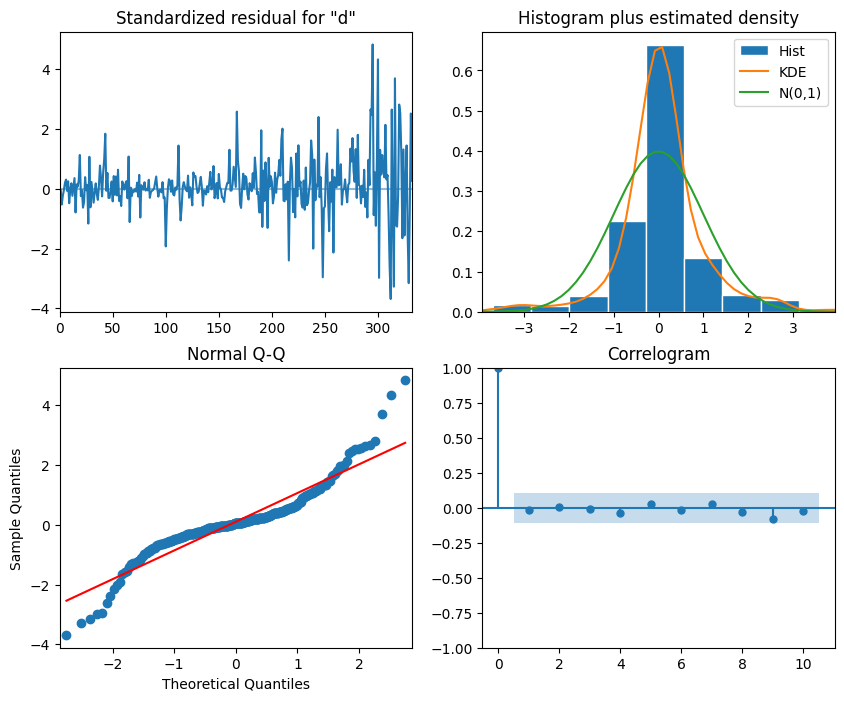

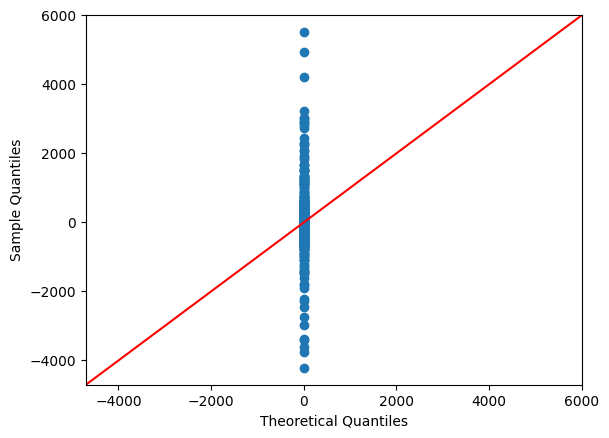

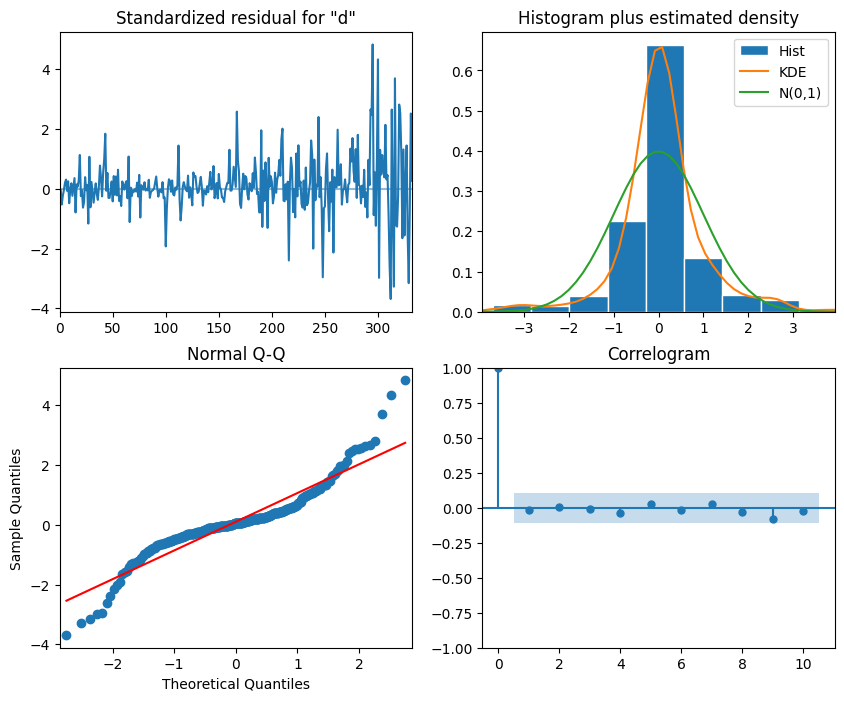

In [40]:
from statsmodels.graphics.gofplots import qqplot
qqplot(residuals, line='45')
model_fit.plot_diagnostics(figsize=(10, 8))

In [41]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(residuals, np.arange(1, 11, 1))


,lb_stat,lb_pvalue
1,0.113836,0.735818
2,0.123654,0.940046
3,0.167231,0.982697
4,0.576953,0.965590
5,0.761951,0.979396
6,0.828874,0.991277
7,1.011885,0.994635
8,1.365768,0.994719
9,3.546029,0.938679
10,3.754801,0.957731


In [43]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    end_idx = train_len
    if method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean
    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value
    elif method == 'ARMA':
        pred_ARMA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,5))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
        return pred_ARMA

In [45]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 5

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_ARMA'] = pred_ARMA

pred_df.head()

c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,diff_bitcoin,pred_mean,pred_last_value,pred_ARMA
333,1058.467452,120.55066,-671.199312,-88.321247
334,466.441293,120.55066,-671.199312,-0.904993
335,2268.805669,120.55066,-671.199312,763.137393
336,-2492.341115,120.55066,-671.199312,-543.410398
337,1448.863607,120.55066,-671.199312,278.247113


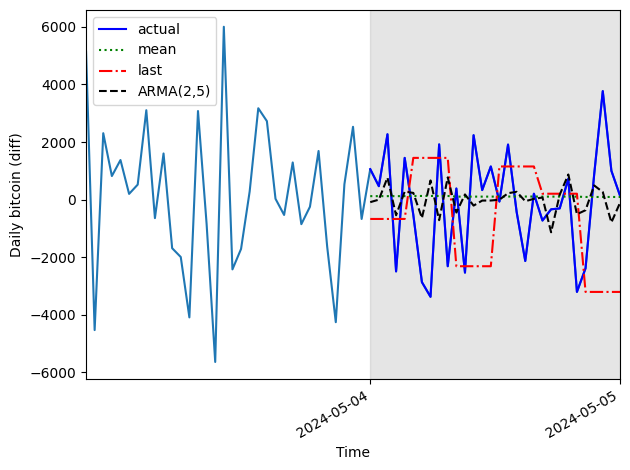

In [54]:
fig, ax = plt.subplots()

ax.plot(df_diff['diff_bitcoin'])
ax.plot(pred_df['diff_bitcoin'], 'b-', label='actual')
ax.plot(pred_df["pred_mean"], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_ARMA'], 'k--', label='ARMA(2,5)')
ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Daily bitcoin (diff)')

ax.axvspan(333, 362, color='#808080', alpha=0.2)
ax.set_xlim(300, 362)
plt.xticks([333, 362], ['2024-05-04', '2024-05-05'])

fig.autofmt_xdate()
plt.tight_layout()

MSE to evaluate the performance

In [56]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['diff_bitcoin'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['diff_bitcoin'], pred_df['pred_last_value'])
mse_ARMA = mean_squared_error(pred_df['diff_bitcoin'], pred_df['pred_ARMA'])
print(mse_mean, mse_last, mse_ARMA)

3325769.430359974 8405267.462717418 3302293.8733085203


Reverse the transformation

In [59]:
bitcoin['pred_bandwidth'] = pd.Series()
bitcoin['pred_bandwidth'][334:] = bitcoin['close'].iloc[334] + pred_df['pred_ARMA'].cumsum()

C:\Users\baloochyb\AppData\Local\Temp\ipykernel_1056\2003357947.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  bitcoin['pred_bandwidth'][334:] = bitcoin['close'].iloc[334] + pred_df['pred_ARMA'].cumsum()
C:\Users\baloochyb\AppData\Local

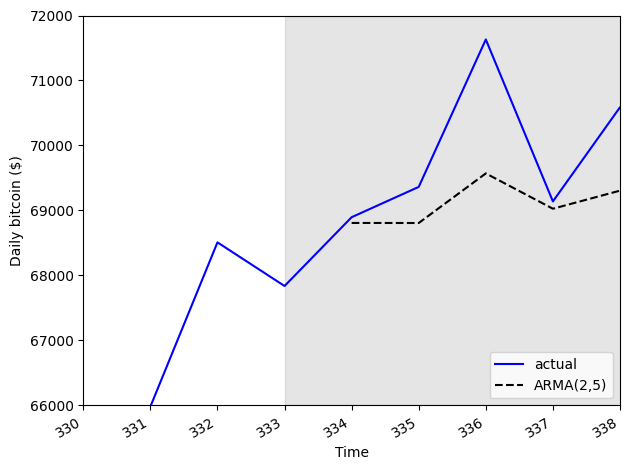

In [69]:
fig, ax = plt.subplots()

ax.plot(bitcoin['close'], 'b-', label='actual')
ax.plot(bitcoin['pred_bandwidth'], 'k--', label='ARMA(2,5)')
ax.legend(loc=4)
ax.set_xlabel('Time')
ax.set_ylabel('Daily bitcoin ($)')
ax.axvspan(333, 363, color='#808080', alpha=0.2)
ax.set_xlim(330, 338)
ax.set_ylim(66000, 72000)
# plt.xticks([333, 363], ['2024-05-04', '2024-05-05'])
fig.autofmt_xdate()
plt.tight_layout()

MAE to evaluate the performance

In [70]:
from sklearn.metrics import mean_absolute_error

mae_ARMA_undiff = mean_absolute_error(bitcoin['close'][334:], bitcoin['pred_bandwidth'][334:])
print(mae_ARMA_undiff)

4551.860150097466


Autoregressive integrated moving average model (ARIIMA)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

bitcoin = pd.read_csv('Bitcoin2.csv', sep=';')
bitcoin = bitcoin.iloc[::-1].reset_index(drop=True)

In [2]:
from statsmodels.tsa.stattools import adfuller
eps_diff = np.diff(bitcoin['close'], n=1)
ad_fuller_result = adfuller(eps_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.9772361266985063
p-value: 0.0015345140737444093


In [3]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [4]:
from itertools import product

ps = range(0, 9, 1)
qs = range(0, 9, 1)
d = 1

order_list = list(product(ps, qs))

In [5]:
train = bitcoin.close[:-30]
test = bitcoin.close[-30:]

result_df = optimize_ARIMA(train, order_list, d)
result_df

C:\Users\baloochyb\AppData\Local\Temp\ipykernel_16108\3816043480.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/81 [00:00<?, ?it/s]

c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA pa

,"(p,q)",AIC
0,"(2, 1)",5639.467301
1,"(2, 5)",5640.497156
2,"(4, 3)",5640.526045
3,"(1, 3)",5640.625227
4,"(5, 2)",5640.764447
...,...,...
76,"(5, 6)",5651.255600
77,"(8, 4)",5653.008819
78,"(7, 7)",5654.720235
79,"(8, 8)",5656.218135


c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


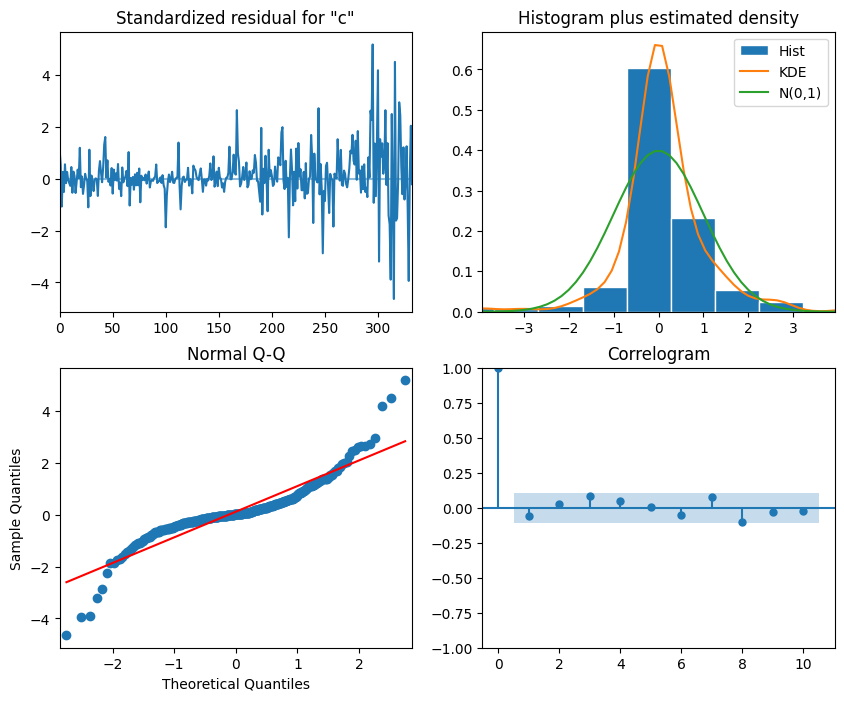

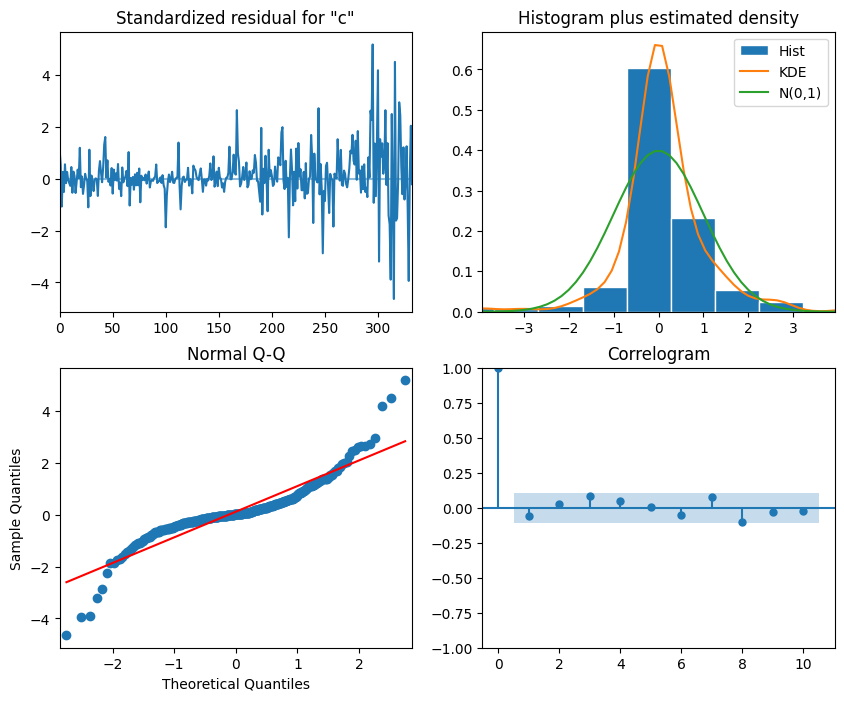

In [11]:
model = SARIMAX(train, order=(2,1,1), simple_differencing=False)
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(10,8))

In [13]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.010442,0.918610
2,0.154652,0.925588
3,0.154693,0.984549
4,0.312142,0.989017
5,0.399653,0.995339
6,0.417541,0.998702
7,0.547809,0.999252
8,0.901541,0.998797
9,0.989364,0.999462
10,1.077550,0.999758


In [99]:
test = bitcoin.iloc[-30:]
test['naive_seasonal'] = bitcoin['close'].iloc[304:334].values

C:\Users\baloochyb\AppData\Local\Temp\ipykernel_16108\3552134467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['naive_seasonal'] = bitcoin['close'].iloc[304:334].values


In [113]:
ARIMA_pred = model_fit.get_prediction(334, 363).predicted_mean
test['ARIMA_pred'] = ARIMA_pred


C:\Users\baloochyb\AppData\Local\Temp\ipykernel_16108\1857721021.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_pred'] = ARIMA_pred


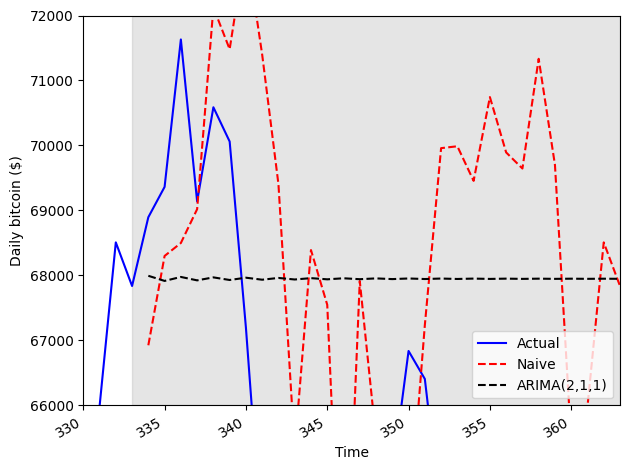

In [115]:
fig, ax = plt.subplots()

ax.plot(bitcoin['close'], 'b-', label='Actual')
ax.plot(test['naive_seasonal'], 'r--', label='Naive')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(2,1,1)')
ax.legend(loc=4)
ax.set_xlabel('Time')
ax.set_ylabel('Daily bitcoin ($)')
ax.axvspan(333, 363, color='#808080', alpha=0.2)
ax.set_xlim(330, 363)
ax.set_ylim(66000, 72000)
# plt.xticks([333, 363], ['2024-05-04', '2024-05-05'])
fig.autofmt_xdate()
plt.tight_layout()

## Seasonal Autoregressive Integrated Moving Average (SARIMA) ##

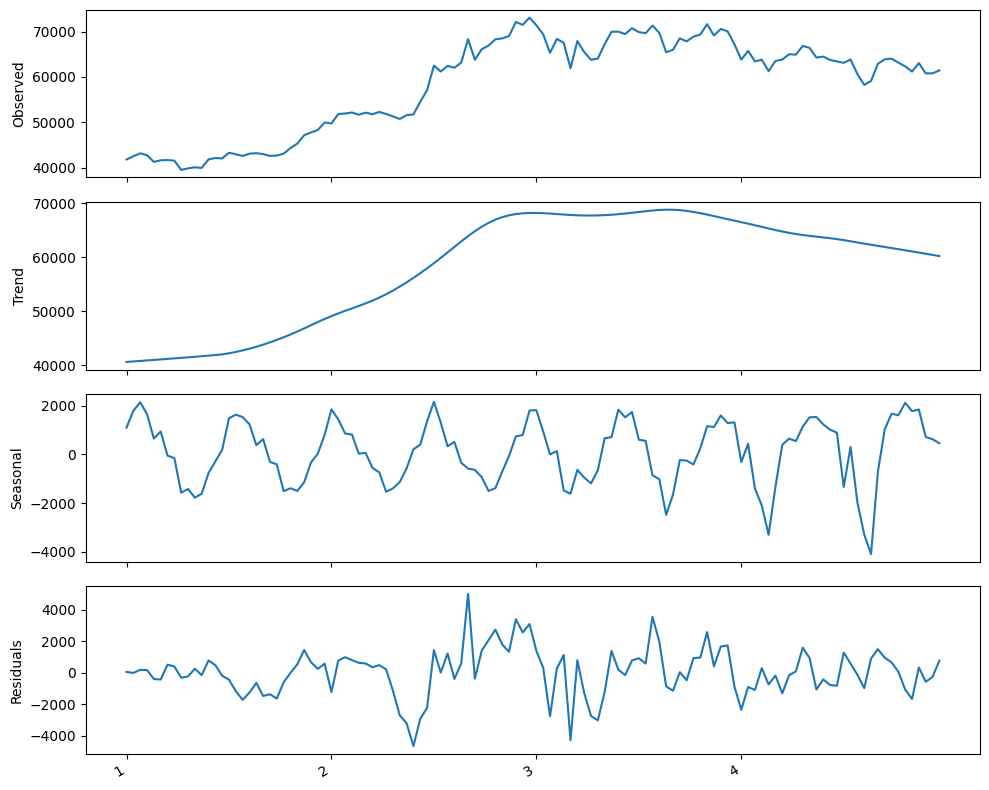

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

bitcoin = pd.read_csv('Bitcoin3.csv', sep=';')
bitcoin = bitcoin.iloc[::-1].reset_index(drop=True)


decomposition = STL(bitcoin['close'], period=15).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))
ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')
ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')
plt.xticks(np.arange(0, 120, 30), np.arange(1, 5, 1))
fig.autofmt_xdate()
plt.tight_layout()

In [50]:
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(bitcoin['close'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.5426708815699335
p-value: 0.5123070713993901


In [85]:
df_diff = np.diff(bitcoin['close'], n=1) 
ad_fuller_result = adfuller(df_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -12.470595409863598
p-value: 3.251438926278528e-23


In [55]:
from itertools import product

ps = range(0, 16, 1) 
qs = range(0, 16, 1) 
Ps = [0] 
Qs = [0]

d = 1
D = 0
s = 15

ARIMA_order_list = list(product(ps, qs, Ps, Qs))

In [56]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), seasonal_order=(order[2], D, order[3], s), simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [57]:
train = bitcoin['close'][:-15]
ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s) 
ARIMA_result_df

C:\Users\baloochyb\AppData\Local\Temp\ipykernel_24864\2428657322.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/256 [00:00<?, ?it/s]

c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

,"(p,q,P,Q)",AIC
0,"(0, 0, 0, 0)",1866.932056
1,"(1, 0, 0, 0)",1868.640844
2,"(0, 1, 0, 0)",1868.643076
3,"(2, 0, 0, 0)",1870.431679
4,"(0, 2, 0, 0)",1870.435509
...,...,...
251,"(15, 13, 0, 0)",1906.451521
252,"(15, 11, 0, 0)",1907.255820
253,"(13, 15, 0, 0)",1907.949965
254,"(14, 15, 0, 0)",1908.415565


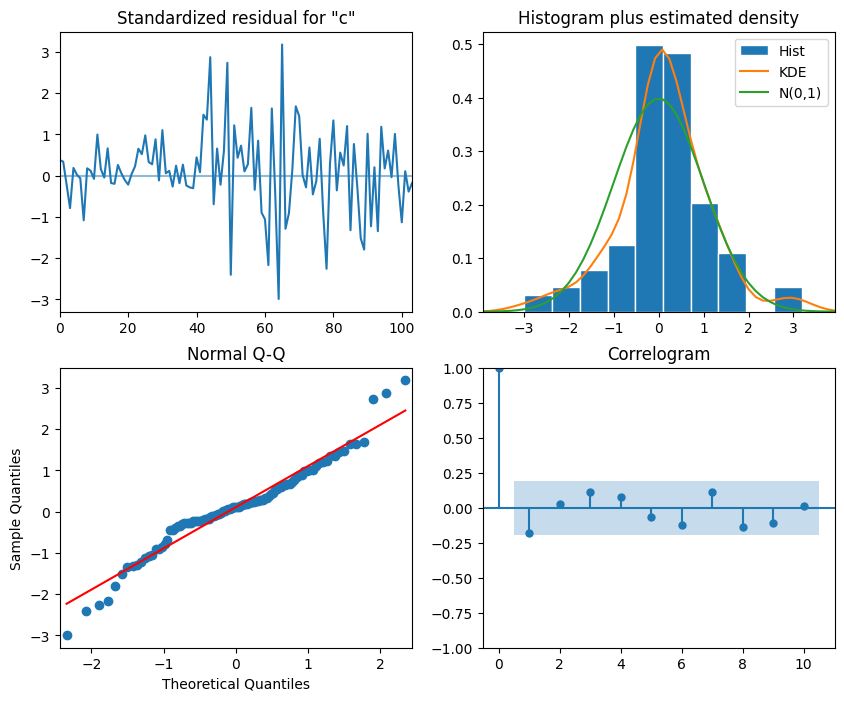

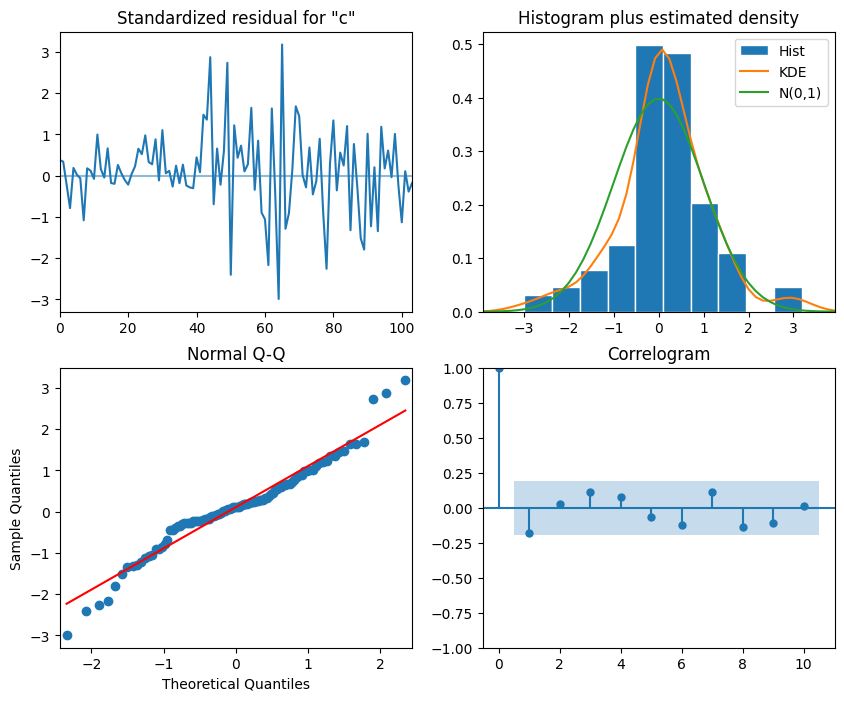

In [58]:
ARIMA_model = SARIMAX(train, order=(0,1,0), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)
ARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [60]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals = ARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.053735,0.816687
2,0.071072,0.965088
3,0.076045,0.994548
4,0.123991,0.998156
5,0.136209,0.999653
6,0.218413,0.999800
7,0.233558,0.999957
8,0.819883,0.999150
9,0.858916,0.999700
10,0.859095,0.999915


In [81]:
test = bitcoin.iloc[-15:]
test['naive_seasonal'] = bitcoin['close'].iloc[90:105].values
ARIMA_pred = ARIMA_model_fit.get_prediction(105, 120).predicted_mean
test['ARIMA_pred'] = ARIMA_pred

C:\Users\baloochyb\AppData\Local\Temp\ipykernel_24864\312533441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['naive_seasonal'] = bitcoin['close'].iloc[90:105].values
C:\Users\baloochyb\AppData\Local\Temp\ipykernel_24864\312533441.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_pred'] = ARIMA_pred


SARIMA Application

In [86]:
ps = range(0, 4, 1) 
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)
SARIMA_order_list = list(product(ps, qs, Ps, Qs))
d = 1
D = 0
s = 15

In [87]:
SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s) 
SARIMA_result_df

C:\Users\baloochyb\AppData\Local\Temp\ipykernel_24864\2428657322.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/256 [00:00<?, ?it/s]

c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: Us

,"(p,q,P,Q)",AIC
0,"(0, 0, 0, 3)",1865.561946
1,"(0, 0, 1, 3)",1866.447571
2,"(0, 0, 0, 0)",1866.932056
3,"(1, 0, 0, 3)",1867.490080
4,"(0, 1, 0, 3)",1867.649959
...,...,...
251,"(3, 1, 1, 2)",1879.861417
252,"(2, 3, 2, 2)",1880.102867
253,"(3, 3, 1, 2)",1881.114068
254,"(3, 3, 2, 1)",1881.163545


Model Selected: SARIMA(0,1,0)(0,0,3)15

c:\Users\baloochyb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


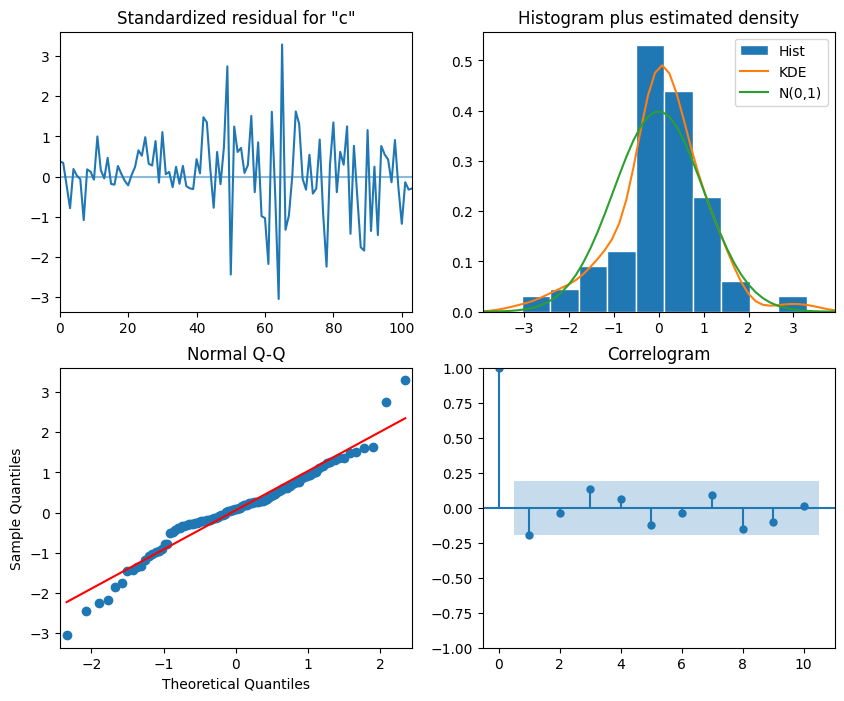

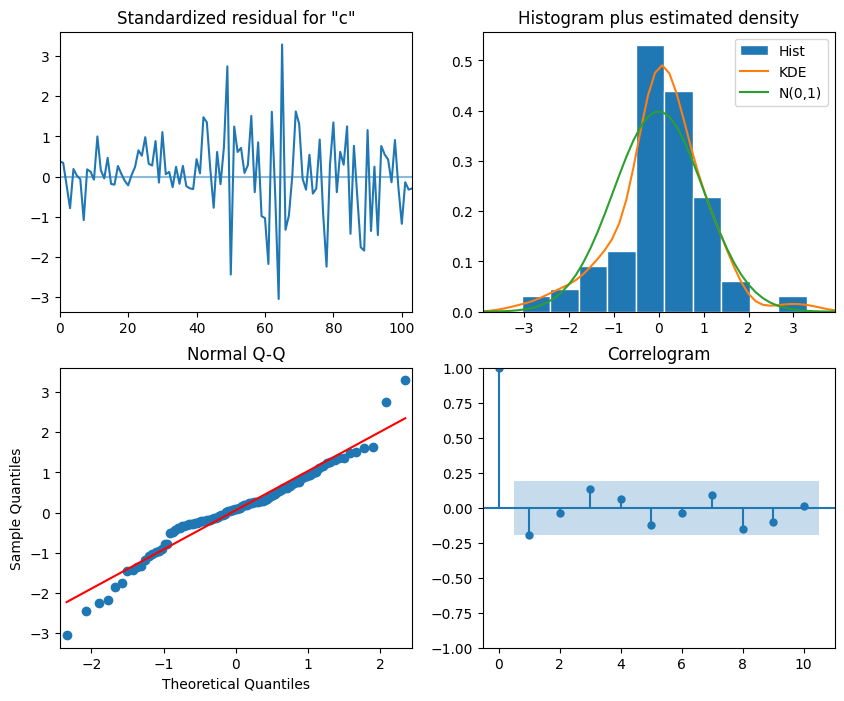

In [88]:
SARIMA_model = SARIMAX(train, order=(0,1,0), seasonal_order=(0,0,3,15), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [89]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals = SARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.046529,0.829217
2,0.048717,0.975936
3,0.063870,0.995788
4,0.118984,0.998299
5,0.150361,0.999558
6,0.160088,0.999919
7,0.169061,0.999986
8,0.737616,0.999425
9,0.762030,0.999818
10,0.763352,0.999951


In [90]:
SARIMA_pred = SARIMA_model_fit.get_prediction(105, 120).predicted_mean 
test['SARIMA_pred'] = SARIMA_pred

C:\Users\baloochyb\AppData\Local\Temp\ipykernel_24864\2522712433.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMA_pred'] = SARIMA_pred


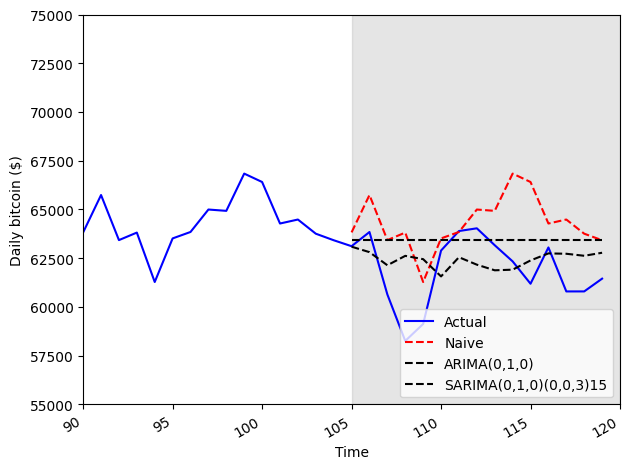

In [91]:
fig, ax = plt.subplots()

ax.plot(bitcoin['close'], 'b-', label='Actual')
ax.plot(test['naive_seasonal'], 'r--', label='Naive')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(0,1,0)')
ax.plot(test['SARIMA_pred'], 'k--', label='SARIMA(0,1,0)(0,0,3)15')
ax.legend(loc=4)
ax.set_xlabel('Time')
ax.set_ylabel('Daily bitcoin ($)')
ax.axvspan(105, 120, color='#808080', alpha=0.2)
ax.set_xlim(90, 120)
ax.set_ylim(55000, 75000)
# plt.xticks([333, 363], ['2024-05-04', '2024-05-05'])
fig.autofmt_xdate()
plt.tight_layout()